# 1.Metadata EDA

In [19]:
import os
import re
import string
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from nltk import pos_tag
from collections import Counter
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from ydata_profiling import ProfileReport
from stanfordcorenlp import StanfordCoreNLP

In [20]:
current_directory = os.getcwd()
project_directory = '/home/jovyan/work/CSC8639/'

if current_directory == project_directory:
    print("The current working directory is already the specified directory, no change needed.")
else:
    os.chdir(project_directory)
    print(f"The current working directory has been changed to: {project_directory}")

The current working directory has been changed to: /home/jovyan/work/CSC8639/


## 1.2 Overview

In [15]:
metadata_file_path = 'mimic-cxr-jpg-v2.1.0/Data/mimic-cxr-2.0.0-metadata.csv'
metadata_df = pd.read_csv(metadata_file_path)
metadata_df.head()

dicom_id  subject_id  study_id  \
0  02aa804e-bde0afdd-112c0b34-7bc16630-4e384014    10000032  50414267   
1  174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962    10000032  50414267   
2  2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab    10000032  53189527   
3  e084de3b-be89b11e-20fe3f9f-9c8d8dfe-4cfd202c    10000032  53189527   
4  68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714    10000032  53911762   

  PerformedProcedureStepDescription ViewPosition  Rows  Columns  StudyDate  \
0                CHEST (PA AND LAT)           PA  3056     2544   21800506   
1                CHEST (PA AND LAT)      LATERAL  3056     2544   21800506   
2                CHEST (PA AND LAT)           PA  3056     2544   21800626   
3                CHEST (PA AND LAT)      LATERAL  3056     2544   21800626   
4               CHEST (PORTABLE AP)           AP  2705     2539   21800723   

    StudyTime ProcedureCodeSequence_CodeMeaning ViewCodeSequence_CodeMeaning  \
0  213014.531                CHEST (PA AND LAT)             postero-anterior   
1  213014.531                CHEST (PA AND LAT)                      lateral   
2  165500.312                CHEST (PA AND LAT)             postero-anterior   
3  165500.312                CHEST (PA AND LAT)                      lateral   
4   80556.875               CHEST (PORTABLE AP)             antero-posterior   

  PatientOrientationCodeSequence_CodeMeaning  
0                                      Erect  
1                                      Erect  
2                                      Erect  
3                                      Erect  
4                                        NaN

In [4]:
metadata_profile = ProfileReport(metadata_df, title = 'mimic-cxr-jpg metadata profiling report')
metadata_profile.to_notebook_iframe()
# metadata_profile.to_file('mimic-cxr-jpg-v2.1.0/EDA/mimic-cxr-jpg metadata profiling report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## 1.2 EDA

#### (1) PerformedProcedureStepDescription

There are multiple types of chest X-ray imaging methods in the data, among which CHEST (PA AND LAT) and CHEST (PORTABLE AP) are the most common methods. The number of X-rays from other imaging methods is relatively low in proportion.

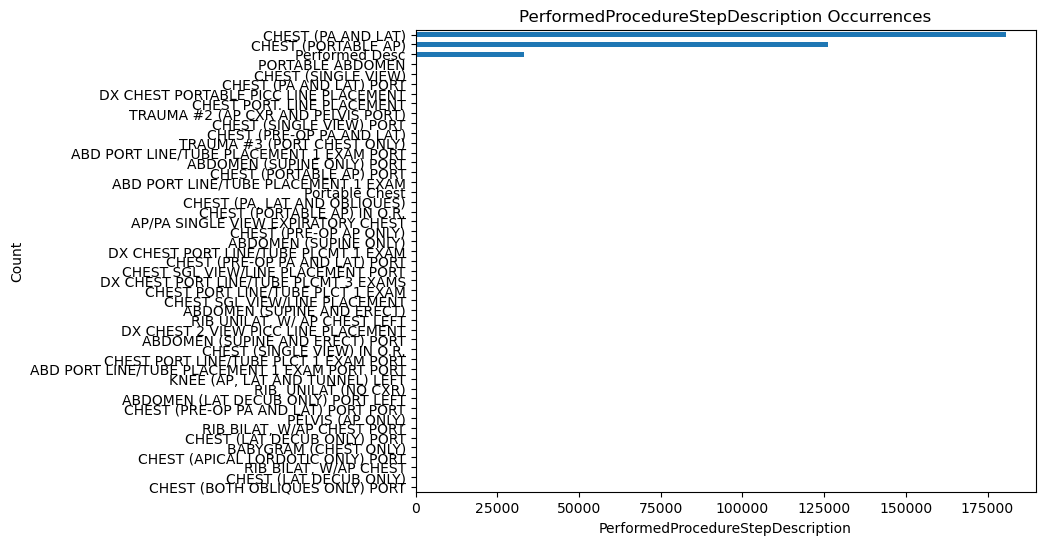

In [8]:
performed_procedure_step_description_value_counts = metadata_df['PerformedProcedureStepDescription'].value_counts().sort_values(ascending=True)

plt.figure(figsize=(8, 6))
performed_procedure_step_description_value_counts.plot(kind='barh')
plt.title('PerformedProcedureStepDescription Occurrences')
plt.xlabel('PerformedProcedureStepDescription')
plt.ylabel('Count')
plt.show()

Solution: Group X-rays from imaging methods other than CHEST (PA AND LAT) and CHEST (PORTABLE AP) into an "Others" category.

In [10]:
performed_procedure_step_description_specific_values = ['CHEST (PA AND LAT)', 'CHEST (PORTABLE AP)']

metadata_df['PerformedProcedureStepDescription_Alteration'] = metadata_df['PerformedProcedureStepDescription'].apply(
    lambda x: x if x in performed_procedure_step_description_specific_values else 'OTHERS'
)

performed_procedure_step_description_alteration_value_counts = metadata_df['PerformedProcedureStepDescription_Alteration'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(
    autopct='%1.1f%%', startangle=140, 
    x=performed_procedure_step_description_alteration_value_counts, 
    labels=performed_procedure_step_description_alteration_value_counts.index)
plt.title('PerformedProcedureStepDescription Distribution')
plt.show()

#### (2) ViewPosition

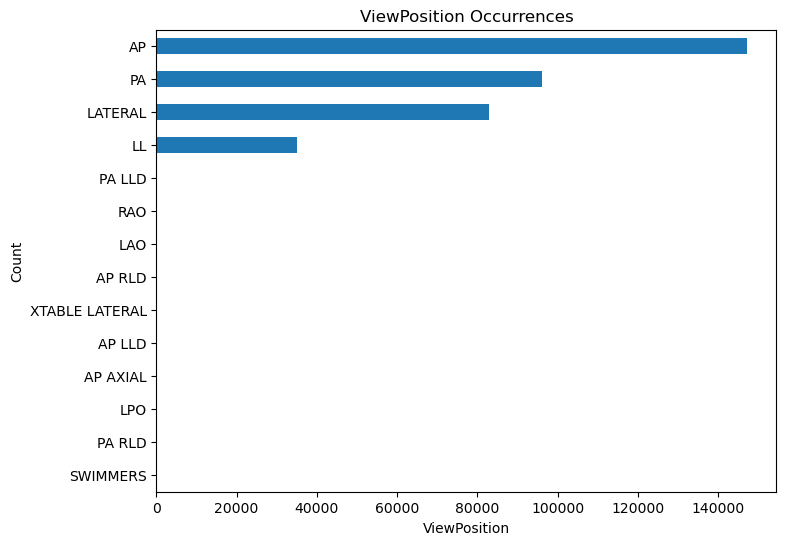

In [9]:
view_position_value_counts = metadata_df['ViewPosition'].value_counts().sort_values(ascending=True)

plt.figure(figsize=(8, 6))
view_position_value_counts.plot(kind='barh')
plt.title('ViewPosition Occurrences')
plt.xlabel('ViewPosition')
plt.ylabel('Count')
plt.show()

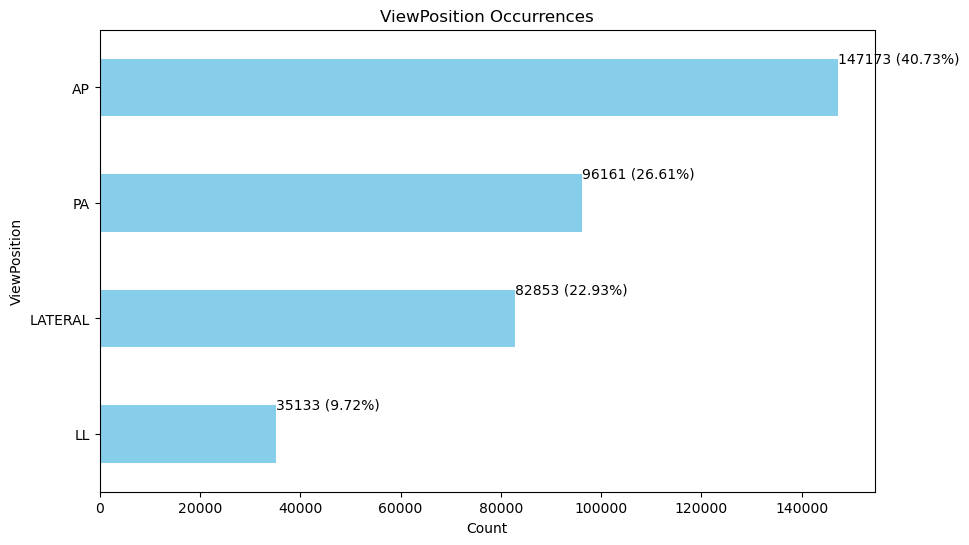

In [17]:
# 假设 metadata_df 已经定义并包含 'ViewPosition' 列
# 计算 'ViewPosition' 的值计数并筛选数量大于10的项
view_position_value_counts = metadata_df['ViewPosition'].value_counts()
view_position_value_counts = view_position_value_counts[view_position_value_counts > 10].sort_values(ascending=True)

# 计算百分比
total_counts = view_position_value_counts.sum()
percentages = (view_position_value_counts / total_counts) * 100

# 创建条形图
plt.figure(figsize=(10, 6))

ax = view_position_value_counts.plot(kind='barh', color='skyblue')

# 添加数量和百分比标签
for i in ax.patches:
    ax.text(i.get_width() + 0.5, i.get_y() + 0.5,
            f'{i.get_width()} ({(i.get_width() / total_counts) * 100:.2f}%)',
            ha='left', va='center', fontsize=10)

# 设置标题和轴标签
plt.title('ViewPosition Occurrences')
plt.xlabel('Count')
plt.ylabel('ViewPosition')
plt.show()

In [12]:
view_position_specific_values = ['AP', 'PA', 'LATERAL', 'LL']

metadata_df['ViewPosition_Alteration'] = metadata_df['ViewPosition'].apply(
    lambda x: x if x in view_position_specific_values else 'OTHERS'
)

view_position_alteration_value_counts = metadata_df['ViewPosition_Alteration'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(
    autopct='%1.1f%%', startangle=140, 
    x=view_position_alteration_value_counts, 
    labels=view_position_alteration_value_counts.index)
plt.title('ViewPosition Distribution')
plt.show()

#### (3) ProcedureCodeSequence_CodeMeaning

In [13]:
procedure_code_sequence_code_meaning_value_counts = metadata_df['ProcedureCodeSequence_CodeMeaning'].value_counts().sort_values(ascending=True)

plt.figure(figsize=(8, 6))
procedure_code_sequence_code_meaning_value_counts.plot(kind='barh')
plt.title('ProcedureCodeSequence_CodeMeaning Occurrences')
plt.xlabel('ProcedureCodeSequence_CodeMeaning')
plt.ylabel('Count')
plt.show()

In [14]:
procedure_code_sequence_code_meaning_specific_values = ['CHEST (PA AND LAT)', 'CHEST (PORTABLE AP)']

metadata_df['ProcedureCodeSequence_CodeMeaning_Alteration'] = metadata_df['ProcedureCodeSequence_CodeMeaning'].apply(
    lambda x: x if x in procedure_code_sequence_code_meaning_specific_values else 'OTHERS'
)

procedure_code_sequence_code_meaning_alteration_value_counts = metadata_df['ProcedureCodeSequence_CodeMeaning_Alteration'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(
    autopct='%1.1f%%', startangle=140, 
    x=procedure_code_sequence_code_meaning_alteration_value_counts, 
    labels=procedure_code_sequence_code_meaning_alteration_value_counts.index)
plt.title('ProcedureCodeSequence_CodeMeaning Distribution')
plt.show()

# 2.Structured labels EDA

In [15]:
chexpert_file_path = 'mimic-cxr-jpg-v2.1.0/Data/mimic-cxr-2.0.0-chexpert.csv'
chexpert_df = pd.read_csv(chexpert_file_path)
chexpert_df.head()

subject_id  study_id  Atelectasis  Cardiomegaly  Consolidation  Edema  \
0    10000032  50414267          NaN           NaN            NaN    NaN   
1    10000032  53189527          NaN           NaN            NaN    NaN   
2    10000032  53911762          NaN           NaN            NaN    NaN   
3    10000032  56699142          NaN           NaN            NaN    NaN   
4    10000764  57375967          NaN           NaN            1.0    NaN   

   Enlarged Cardiomediastinum  Fracture  Lung Lesion  Lung Opacity  \
0                         NaN       NaN          NaN           NaN   
1                         NaN       NaN          NaN           NaN   
2                         NaN       NaN          NaN           NaN   
3                         NaN       NaN          NaN           NaN   
4                         NaN       NaN          NaN           NaN   

   No Finding  Pleural Effusion  Pleural Other  Pneumonia  Pneumothorax  \
0         1.0               NaN            NaN        NaN           NaN   
1         1.0               NaN            NaN        NaN           NaN   
2         1.0               NaN            NaN        NaN           NaN   
3         1.0               NaN            NaN        NaN           NaN   
4         NaN               NaN            NaN       -1.0           NaN   

   Support Devices  
0              NaN  
1              NaN  
2              NaN  
3              NaN  
4              NaN

In [16]:
chexpert_profile = ProfileReport(chexpert_df, title = 'mimic-cxr-jpg chexpert profiling report')
# chexpert_profile.to_notebook_iframe()
# chexpert_profile.to_file('mimic-cxr-jpg-v2.1.0/EDA/mimic-cxr-jpg chexpert profiling report.html')

In [17]:
negbio_file_path = 'mimic-cxr-jpg-v2.1.0/Data/mimic-cxr-2.0.0-negbio.csv'
negbio_df = pd.read_csv(negbio_file_path)
negbio_df.head()

subject_id  study_id  Atelectasis  Cardiomegaly  Consolidation  Edema  \
0    10000032  50414267          NaN           NaN            NaN    NaN   
1    10000032  53189527          NaN           NaN            NaN    NaN   
2    10000032  53911762          NaN           NaN            NaN    NaN   
3    10000032  56699142          NaN           NaN            NaN    NaN   
4    10000764  57375967          NaN           NaN            1.0    NaN   

   Enlarged Cardiomediastinum  Fracture  Lung Lesion  Lung Opacity  \
0                         NaN       NaN          NaN           NaN   
1                         NaN       NaN          NaN           NaN   
2                         NaN       NaN          NaN           NaN   
3                         NaN       NaN          NaN           NaN   
4                         NaN       NaN          NaN           NaN   

   No Finding  Pleural Effusion  Pleural Other  Pneumonia  Pneumothorax  \
0         1.0               NaN            NaN        NaN           NaN   
1         1.0               NaN            NaN        NaN           NaN   
2         1.0               NaN            NaN        NaN           NaN   
3         1.0               NaN            NaN        NaN           NaN   
4         NaN               NaN            NaN       -1.0           NaN   

   Support Devices  
0              NaN  
1              NaN  
2              NaN  
3              NaN  
4              NaN

In [18]:
negbio_profile = ProfileReport(negbio_df, title = 'mimic-cxr-jpg negbio profiling report')
negbio_profile.to_notebook_iframe()
# negbio_profile.to_file('mimic-cxr-jpg-v2.1.0/EDA/mimic-cxr-jpg negbio profiling report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# 3.Radiology Reports

(1) Reading data

In [20]:
radiology_report_folder_path = 'minic-cxr-v2.0.0/files'
radiology_report_excel_filename = 'mimic-cxr-jpg-v2.1.0/Data/minic-cxr-v2.0.0-report.xlsx'
radiology_report = []

for root, dirs, files in tqdm(os.walk(radiology_report_folder_path), desc="Processing files", total=len(os.listdir(radiology_report_folder_path))):
    subject_id = os.path.basename(root)[1:]
    for file in files:
        if file.endswith('.txt'):
            file_path = os.path.join(root, file)
            with open(file_path, 'r', encoding='utf-8') as f:
                content = f.read()
            study_id = os.path.splitext(file)[0][1:]
            radiology_report.append({'folder_name': subject_id[0:2], 'subject_id': subject_id ,'study_id': study_id, 'report': content})

radiology_report_df = pd.DataFrame(radiology_report)

Processing files: 65399it [01:12, 905.88it/s]           


(2) Forming image-report pairs by combining images and reports

In [21]:
def find_jpg_in_folder(case, base_path):
    files = []
    folder_name = f"p{case['folder_name']}"
    subject_folder = f"p{case['subject_id']}"
    study_folder = f"s{case['study_id']}"
        
    complete_path = os.path.join(base_path, folder_name, subject_folder, study_folder)
    
    if not os.path.exists(complete_path):
        return files
    
    for file in os.listdir(complete_path):
        if file.endswith('.jpg'):
            file_path = os.path.join(complete_path, file)
            files.append({'file_name': file, 'file_path': file_path})
    
    return files

In [22]:
radiology_report_df['image_pairs'] = radiology_report_df.apply(find_jpg_in_folder ,axis=1, args=('mimic-cxr-jpg-v2.1.0/Data/files/', ))

(3) Extracting the content of FINDINGS and IMPRESSION from the report

In [23]:
def extract_findings_and_impression(case):
    findings_pattern = r"FINDINGS:(.*?)IMPRESSION:"
    impression_pattern = r"IMPRESSION:(.*)"
    result = {}
    findings_content = ''
    impression_content = ''
    report_text = case['report']
    
    findings_match = re.search(findings_pattern, report_text, re.DOTALL)
    impression_match = re.search(impression_pattern, report_text, re.DOTALL)
    
    if findings_match:
        findings_content = findings_match.group(1).strip()
    
    if impression_match:
        impression_content = impression_match.group(1).strip()
        
    return pd.Series({
        'findings': findings_content,
        'impression': impression_content
    })

In [24]:
radiology_report_df[['findings', 'impression']] = radiology_report_df.apply(extract_findings_and_impression, axis=1)

In [25]:
radiology_report_df[:5]

folder_name subject_id  study_id  \
0          10   10000032  50414267   
1          10   10000032  53189527   
2          10   10000032  53911762   
3          10   10000032  56699142   
4          10   10000764  57375967   

                                              report  \
0                                   FINAL REPORT\...   
1                                   FINAL REPORT\...   
2                                   FINAL REPORT\...   
3                                   FINAL REPORT\...   
4                                   FINAL REPORT\...   

                                         image_pairs  \
0  [{'file_name': '02aa804e-bde0afdd-112c0b34-7bc...   
1  [{'file_name': '2a2277a9-b0ded155-c0de8eb9-c12...   
2  [{'file_name': '68b5c4b1-227d0485-9cc38c3f-7b8...   
3  [{'file_name': 'ea030e7a-2e3b1346-bc518786-7a8...   
4  [{'file_name': '096052b7-d256dc40-453a102b-fa7...   

                                            findings  \
0  There is no focal consolidation, pleural effus...   
1  The cardiac, mediastinal and hilar contours ar...   
2  Single frontal view of the chest provided.\n \...   
3  The lungs are clear of focal consolidation, pl...   
4  PA and lateral views of the chest provided.   ...   

                                          impression  
0                  No acute cardiopulmonary process.  
1              No acute cardiopulmonary abnormality.  
2                    No acute intrathoracic process.  
3                  No acute cardiopulmonary process.  
4  Focal consolidation at the left lung base, pos...

(4) Removing stopwords from FINDINGS and IMPRESSION

In [30]:
def sentence_tokenize(sentence, stanfordcorenlp):
    tokenize = stanfordcorenlp.word_tokenize(sentence)
    return tokenize
    
def remove_sentence_stopwords(tokenized_list):
    stop_words = set(stopwords.words('english'))
    return [word for word in tokenized_list if word.lower() not in stop_words]

def word_pos_tag(sentence, stanfordcorenlp):
    pos_tags = stanfordcorenlp.pos_tag(sentence)
    return pos_tags
    
def remove_sentence_punctuation(tokenized_list):
    punctuations = string.punctuation
    return [word for word in tokenized_list if word not in punctuations]

def remove_sentence_contractions(tokenized_list, whitelist = ["n't", "not", "no"]):
    return [word for word in tokenized_list if "'" not in word or word in whitelist]

def remove_sentence_specific_words(tokenized_list, words_to_remove):
    return [word for word in tokenized_list if word not in words_to_remove]

def remove_sentence_numeric(tokenized_list):
    return [word for word in tokenized_list if not word.isnumeric()]

def filter_sentence_token(text, stanfordcorenlp):
    tokenized = sentence_tokenize(text, stanfordcorenlp)
    filtered_tokenized = remove_sentence_stopwords(tokenized)
    return filtered_tokenized

def sentence_pos_tag(text, stanfordcorenlp):
    pos_tags = word_pos_tag(text, stanfordcorenlp)
    return pos_tags

In [31]:
stanfordcorenlp_dependency_path = 'dependency/stanford-corenlp-4.5.7'
stanfordcorenlp = StanfordCoreNLP(stanfordcorenlp_dependency_path)

radiology_report_df['findings_tokens'] = radiology_report_df['findings'].apply(
    filter_sentence_token, args=(stanfordcorenlp, ))
radiology_report_df['impression_tokens'] = radiology_report_df['impression'].apply(
    filter_sentence_token, args=(stanfordcorenlp, ))
radiology_report_df['findings_pos_tags'] = radiology_report_df['findings'].apply(
    sentence_pos_tag, args=(stanfordcorenlp, ))
radiology_report_df['impression_pos_tags'] = radiology_report_df['impression'].apply(
    sentence_pos_tag, args=(stanfordcorenlp, ))

stanfordcorenlp.close()

In [32]:
radiology_report_df['findings_tokens'][:5]

0    [focal, consolidation, ,, pleural, effusion, p...
1    [cardiac, ,, mediastinal, hilar, contours, nor...
2    [Single, frontal, view, chest, provided, ., fo...
3    [lungs, clear, focal, consolidation, ,, pleura...
4    [PA, lateral, views, chest, provided, ., lungs...
Name: findings_tokens, dtype: object

In [33]:
radiology_report_df['impression_tokens'][:5]

0                 [acute, cardiopulmonary, process, .]
1             [acute, cardiopulmonary, abnormality, .]
2                   [acute, intrathoracic, process, .]
3                 [acute, cardiopulmonary, process, .]
4    [Focal, consolidation, left, lung, base, ,, po...
Name: impression_tokens, dtype: object

In [34]:
radiology_report_df['findings_pos_tags'][:5]

0    [(There, EX), (is, VBZ), (no, DT), (focal, JJ)...
1    [(The, DT), (cardiac, JJ), (,, ,), (mediastina...
2    [(Single, JJ), (frontal, JJ), (view, NN), (of,...
3    [(The, DT), (lungs, NNS), (are, VBP), (clear, ...
4    [(PA, NNP), (and, CC), (lateral, JJ), (views, ...
Name: findings_pos_tags, dtype: object

In [35]:
radiology_report_df['impression_pos_tags'][:5]

0    [(No, DT), (acute, JJ), (cardiopulmonary, JJ),...
1    [(No, DT), (acute, JJ), (cardiopulmonary, JJ),...
2    [(No, DT), (acute, JJ), (intrathoracic, JJ), (...
3    [(No, DT), (acute, JJ), (cardiopulmonary, JJ),...
4    [(Focal, JJ), (consolidation, NN), (at, IN), (...
Name: impression_pos_tags, dtype: object

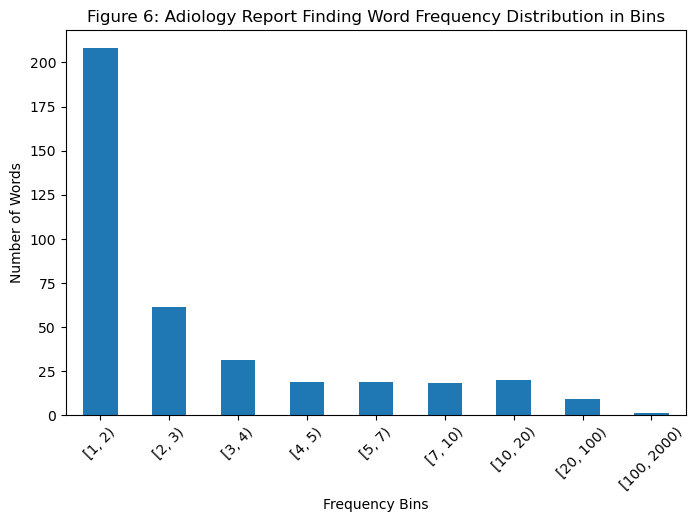

In [37]:
adiology_report_finding_words = sum(radiology_report_df['findings_tokens'][:50], [])
adiology_report_finding_word_counts = Counter(adiology_report_finding_words)
adiology_report_finding_word_freq_df = pd.DataFrame(
    adiology_report_finding_word_counts.items(),  
    columns=['Word', 'Frequency']).sort_values(by = 'Frequency', ascending = False)

bins = [1, 2, 3, 4, 5, 7, 10, 20, 100, 2000]
adiology_report_finding_word_freq_df['Frequency_bin'] = pd.cut(adiology_report_finding_word_freq_df['Frequency'], bins, right = False)
adiology_report_finding_word_frequency_counts = adiology_report_finding_word_freq_df['Frequency_bin'].value_counts().sort_index()

plt.figure(figsize = (8, 5))
adiology_report_finding_word_frequency_counts.plot(kind = 'bar')
plt.xlabel('Frequency Bins')
plt.ylabel('Number of Words')
plt.title('Figure 6: Adiology Report Finding Word Frequency Distribution in Bins')
plt.xticks(rotation = 45)
plt.show()

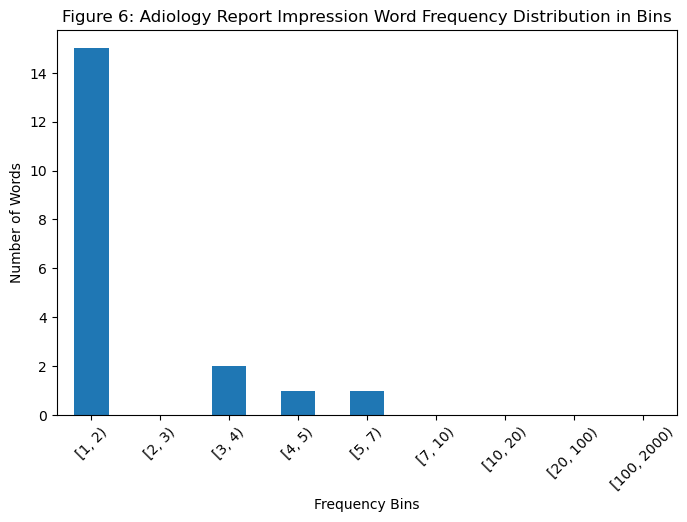

In [38]:
adiology_report_impression_words = sum(radiology_report_df['impression_tokens'][:5], [])
adiology_report_impression_word_counts = Counter(adiology_report_impression_words)
adiology_report_impression_word_freq_df = pd.DataFrame(
    adiology_report_impression_word_counts.items(),  
    columns=['Word', 'Frequency']).sort_values(by = 'Frequency', ascending = False)

bins = [1, 2, 3, 4, 5, 7, 10, 20, 100, 2000]
adiology_report_impression_word_freq_df['Frequency_bin'] = pd.cut(adiology_report_impression_word_freq_df['Frequency'], bins, right = False)
adiology_report_impression_word_frequency_counts = adiology_report_impression_word_freq_df['Frequency_bin'].value_counts().sort_index()

plt.figure(figsize = (8, 5))
adiology_report_impression_word_frequency_counts.plot(kind = 'bar')
plt.xlabel('Frequency Bins')
plt.ylabel('Number of Words')
plt.title('Figure 6: Adiology Report Impression Word Frequency Distribution in Bins')
plt.xticks(rotation = 45)
plt.show()

In [23]:
# radiology_report_df.to_excel(radiology_report_excel_filename, index=False)
# print(f'Radiology report has been saved to {radiology_report_excel_filename}')

In [28]:
from PIL import ImageDraw, Image
image = Image.open('0c27f551-2cc6bf3e-a2e2cabd-97973771-40f1e6ce.jpg') 
draw = ImageDraw.Draw(image)
draw.rectangle([54,695,955,2633], outline=(255,0,0,255))
image.show()

# "original_x1": 54,
# "original_y1": 695,
# "original_x2": 955,
# "original_y2": 2633,

TypeError: color must be int or single-element tuple

In [42]:
from PIL import Image, ImageDraw, ImageEnhance, ImageFont

# 打开原始图像
image = Image.open('0c27f551-2cc6bf3e-a2e2cabd-97973771-40f1e6ce.jpg')

# 创建一个与原始图像大小相同的空白图像，带有透明度通道
overlay = Image.new('RGBA', image.size, (255,255,255,0))

# 在透明图像上绘制矩形
draw = ImageDraw.Draw(overlay)
draw.rectangle([54, 695, 955, 2633], outline=(255, 0, 255, 255), width=10) 
draw.rectangle([1146, 695, 2060, 2346], outline=(0, 0, 255, 255), width=10) 
draw.rectangle([736, 914, 1828, 2319], outline=(0, 255, 255, 255), width=10) 
draw.rectangle([736, 1609, 1828, 2319], outline=(0, 255, 0, 255), width=10) 

# 加载字体 (注意路径和字体文件需要根据实际情况调整)
font = ImageFont.truetype("Arial.ttf", 100)  # 字体和大小

# 在矩形框上添加文字
draw.text((54, 695 - 100), "right lung", fill=(255, 0, 255, 255), font=font)
draw.text((1146, 695 - 100), "left lung", fill=(0, 0, 255, 255), font=font)
draw.text((736, 914 - 100), "mediastinum", fill=(0, 255, 255, 255), font=font)
draw.text((736, 1609 - 100), "cardiac silhouette", fill=(0, 255, 0, 255) , font=font)

# 调整透明度（这里设置为半透明）
alpha = 0.5
overlay = ImageEnhance.Brightness(overlay).enhance(alpha)

# 将透明图像叠加到原始图像上
image = image.convert('RGBA')
combined = Image.alpha_composite(image, overlay)

# 保存结果图像
combined.save('combined_image_with_text.png')

# 提示用户图像已保存
print("图像已保存到 combined_image_with_text.png")

图像已保存到 combined_image_with_text.png


In [47]:
from PIL import Image, ImageDraw, ImageEnhance, ImageFont

# 最终结果数据示例

# 打开原始图像
image = Image.open('02aa804e-bde0afdd-112c0b34-7bc16630-4e384014.jpg')

# 创建一个与原始图像大小相同的空白图像，带有透明度通道
overlay = Image.new('RGBA', image.size, (255,255,255,0))

# 在透明图像上绘制矩形
draw = ImageDraw.Draw(overlay)
draw.rectangle([327, 231, 1200, 2114], outline=(255, 0, 0, 255), width=10) 
draw.rectangle([327, 1391, 1146, 2114], outline=(0, 255, 0, 255), width=10) 
draw.rectangle([791, 873, 1186, 1473], outline=(0, 0, 255, 255), width=10) 
draw.rectangle([191, 1923, 463, 2196], outline=(255, 255, 0, 255), width=10) 
draw.rectangle([1364, 231, 2196, 2210], outline=(0, 255, 255, 255), width=10) 
draw.rectangle([1391, 968, 2128, 1418], outline=(255, 0, 255, 255), width=10) 
draw.rectangle([1391, 1418, 2196, 2210], outline=(255, 165, 0, 255), width=10) 
draw.rectangle([1377, 873, 1759, 1500], outline=(128, 0, 128, 255), width=10) 
draw.rectangle([2060, 2005, 2332, 2278], outline=(0, 128, 128, 255), width=10) 
draw.rectangle([1064, 0, 1418, 3042], outline=(128, 128, 0, 255), width=10) 
draw.rectangle([1418, 368, 2387, 654], outline=(0, 128, 0, 255), width=10) 
draw.rectangle([982, 518, 1814, 2019], outline=(128, 0, 0, 255), width=10) 
draw.rectangle([1105, 518, 1514, 1255], outline=(0, 0, 128, 255), width=10) 
draw.rectangle([982, 1268, 1814, 2019], outline=(192, 192, 192, 255), width=10) 

# (255, 0, 0, 255),     # Red
# (0, 255, 0, 255),     # Green
# (0, 0, 255, 255),     # Blue
# (255, 255, 0, 255),   # Yellow
# (0, 255, 255, 255),   # Cyan
# (255, 0, 255, 255),   # Magenta
# (255, 165, 0, 255),   # Orange
# (128, 0, 128, 255),   # Purple
# (0, 128, 128, 255),   # Teal
# (128, 128, 0, 255),   # Olive
# (0, 128, 0, 255),     # Dark Green
# (128, 0, 0, 255),     # Dark Red
# (0, 0, 128, 255),     # Navy
# (192, 192, 192, 255)  # Silver

# 加载字体 (注意路径和字体文件需要根据实际情况调整)
font = ImageFont.truetype("Arial.ttf", 70)  # 字体和大小

# 在矩形框上添加文字
draw.text((327, 231 - 70), "right lung", fill=(255, 0, 0, 255), font=font)
draw.text((327, 1391  - 70), "right lower lung zone", fill=(0, 255, 0, 255), font=font)
draw.text((791, 873  - 70), "right hilar structures", fill=(0, 0, 255, 255), font=font)
draw.text((191, 1923  - 70), "right costophrenic angle", fill=(255, 255, 0, 255), font=font)
draw.text((1364, 231  - 70), "left lung", fill=(0, 255, 255, 255), font=font)
draw.text((1391, 968  - 70), "left mid lung zone", fill=(255, 0, 255, 255), font=font)
draw.text((1391, 1418  - 70), "left lower lung zone", fill=(255, 165, 0, 255), font=font)
draw.text((1377, 873  - 70), "left hilar structures", fill=(128, 0, 128, 255), font=font)
draw.text((2060, 2005  - 70), "left costophrenic angle", fill=(0, 128, 128, 255), font=font)
draw.text((1064, 0  - 70), "spine", fill=(128, 128, 0, 255), font=font)
draw.text((1418, 368  - 70), "left clavicle", fill=(0, 128, 0, 255), font=font)
draw.text((982, 518  - 70), "mediastinum", fill=(128, 0, 0, 255), font=font)
draw.text((1105, 518  - 70), "upper mediastinum", fill=(0, 0, 128, 255), font=font)
draw.text((982, 1268  - 70), "cardiac silhouette", fill=(192, 192, 192, 255), font=font)

# 调整透明度（这里设置为半透明）
alpha = 0.5
overlay = ImageEnhance.Brightness(overlay).enhance(alpha)

# 将透明图像叠加到原始图像上
image = image.convert('RGBA')
combined = Image.alpha_composite(image, overlay)

# 保存结果图像
combined.save('combined_image_with_text.png')

# 提示用户图像已保存
print("图像已保存到 combined_image_with_text.png")

图像已保存到 combined_image_with_text.png
